# Simulations reported in Section 3

### Enable parallel computing, and load required packages

In [1]:
addprocs(3)

@everywhere using Distributions
using DataFrames, Gadfly, Colors, HypothesisTests

### Graphics defaults

In [2]:
Gadfly.push_theme(:default)

function gen_brew_colors(n)
    cs = distinguishable_colors(n,
        [colorant"#66c2a5", colorant"#fc8d62", colorant"#8da0cb", colorant"#e78ac3",
            colorant"#a6d854", colorant"#ffd92f", colorant"#e5c494", colorant"#b3b3b3"],
        lchoices=Float64[58, 45, 72.5, 90],
        transform=c->deuteranopic(c, 0.1),
        cchoices=Float64[20,40],
        hchoices=[75,51,35,120,180,210,270,310]
    )
    convert(Vector{Color}, cs)
end

set_default_plot_size(9inch, 9inch/golden)

### Set parameters, define priors and likelihoods, and generate data

In [3]:
@everywhere const numb_hyp = 11
@everywhere const numb_toss = 500
@everywhere const numb_sim = 1000

@everywhere const prior = fill(1/numb_hyp, numb_hyp)
@everywhere const likelihood_heads = linspace(0, 1, numb_hyp)
@everywhere const likelihood_tails = linspace(1, 0, numb_hyp)

datFunc(bias) = rand(Bernoulli(bias), numb_toss)

@everywhere sim_dat = Array{Bool, 3}(numb_sim, numb_toss, numb_hyp);

for i in 1:numb_hyp, j in 1:numb_sim
    sim_dat[j, :, i] = datFunc((i - 1) / (numb_hyp - 1))
end

### Update rules

In [4]:
@everywhere function b_upd(probs::Array{Float32, 1}, dat::Array{Bool, 1}, toss_num::Int)
    if dat[toss_num] == 1
        @. (probs * likelihood_heads) / $dot(probs, likelihood_heads)
    else
        @. (probs * likelihood_tails) / $dot(probs, likelihood_tails)
    end
end

In [5]:
@everywhere function expl_upd(probs::Array{Float32, 1}, dat::Array{Bool, 1}, toss_num::Int, bonus::Float64=0.01)
    val::Float32 = mean(dat[1:toss_num]) * 10 + 1
    vec::Array{Float32, 1} = if dat[toss_num] == 1
            @. (probs * likelihood_heads) / $dot(probs, likelihood_heads)
        else
            @. (probs * likelihood_tails) / $dot(probs, likelihood_tails)
        end

    if val % 1 == .5
        vec[floor(Int, val)] += .5*bonus
        vec[ceil(Int, val)] += .5*bonus
    else
        vec[round(Int, val, RoundNearestTiesAway)] += bonus
    end

    return vec / sum(vec)
end

### Running the simulations

In [6]:
bayesRes = SharedArray{Float32, 4}(numb_toss + 1, numb_hyp, numb_sim, numb_hyp)
explRes = SharedArray{Float32, 4}(numb_toss + 1, numb_hyp, numb_sim, numb_hyp)

@inbounds for h in 1:numb_hyp, s in 1:numb_sim
    bayesRes[1, :, s, h] = prior
end

@sync @parallel for h in 1:numb_hyp
    @fastmath @inbounds for s in 1:numb_sim, t in 1:numb_toss
        bayesRes[t + 1, :, s, h] = b_upd(bayesRes[t, :, s, h], sim_dat[s, :, h], t)
    end
end

@inbounds for h in 1:numb_hyp, s in 1:numb_sim
    explRes[1, :, s, h] = prior
end

@sync @parallel for h in 1:numb_hyp
    @fastmath @inbounds for s in 1:numb_sim, t in 1:numb_toss
       explRes[t + 1, :, s, h] = expl_upd(explRes[t, :, s, h], sim_dat[s, :, h], t)
    end
end;

### Convergence

In [7]:
@everywhere function ff(res::SharedArray{Float32, 4}, sim::Int64, bias::Int64, thresh::Float64=.9)
    findfirst(res[:, bias, sim, bias] .> thresh)
end

In [8]:
convResBayes = SharedArray{Int32, 2}(numb_sim, div((numb_hyp - 1), 2))

@sync @parallel for i in 1:div((numb_hyp - 1), 2)
    for j in 1:numb_sim
        convResBayes[j, i] = ff(bayesRes, j, i + 1)
    end
end;

In [9]:
convResBayes[convResBayes.==0] = numb_toss
convB = DataFrame(convert(Array, convResBayes))
names!(convB, [Symbol("$i") for i in .1:.1:.5]);

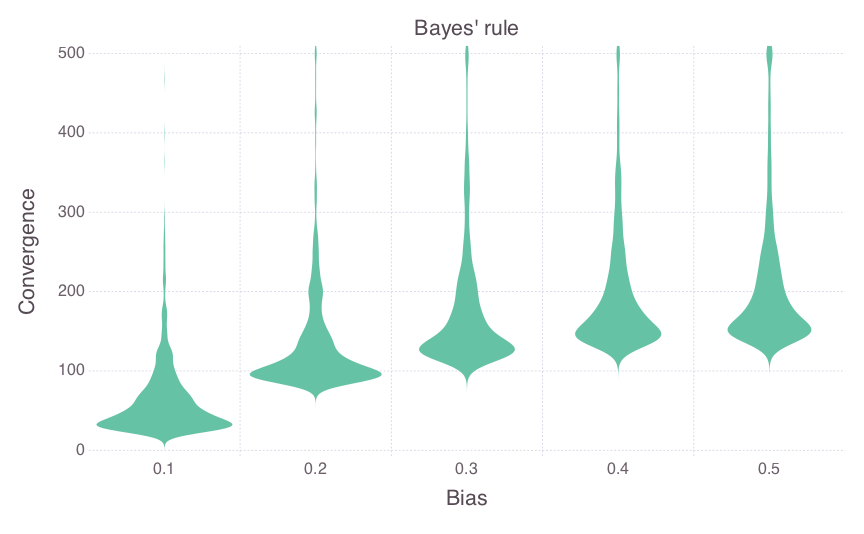

In [10]:
plot(convB,
    x=Col.index,
    y=Col.value,
    Geom.violin,
    Coord.Cartesian(ymin=0, ymax=numb_toss),
    Guide.xlabel("Bias"),
    Guide.ylabel("Convergence"),
    Guide.title("Bayes' rule"),
    Scale.x_discrete(levels=convB.colindex.names),
    style(default_color=colorant"#66c2a5",
        minor_label_font_size=12pt, major_label_font_size=16pt))

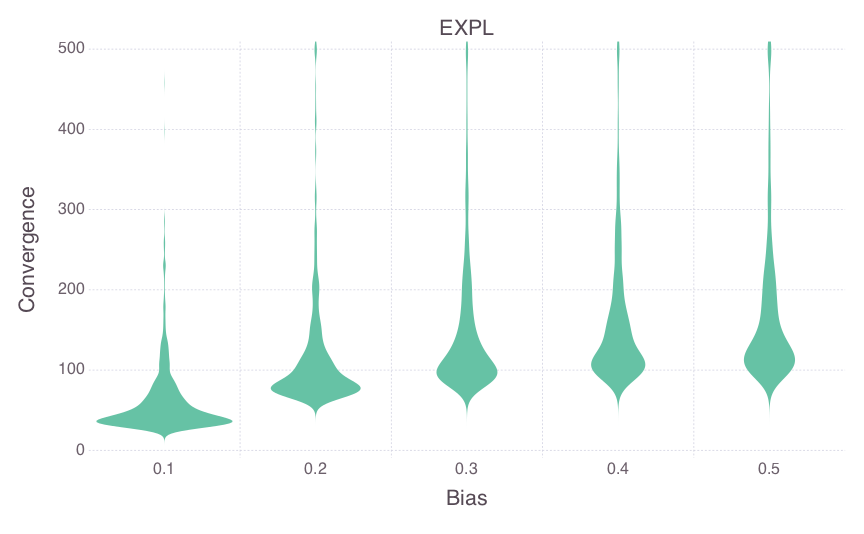

In [11]:
convResEXPL = SharedArray{Int32, 2}(numb_sim, div((numb_hyp - 1), 2))

@sync @parallel for i in 1:div((numb_hyp - 1), 2)
    for j in 1:numb_sim
        @inbounds convResEXPL[j, i] = ff(explRes, j, i + 1)
    end
end

convResEXPL[convResEXPL.==0] = numb_toss
convE = DataFrame(convert(Array, convResEXPL))
names!(convE, [Symbol("$i") for i in .1:.1:.5])

plot(convE,
    x=Col.index,
    y=Col.value,
    Geom.violin,
    Coord.Cartesian(ymin=0, ymax=numb_toss),
    Guide.xlabel("Bias"),
    Guide.ylabel("Convergence"),
    Guide.title("EXPL"),
    Scale.x_discrete(levels=convB.colindex.names),
    style(default_color=colorant"#66c2a5",
        minor_label_font_size=12pt, major_label_font_size=16pt))

### Stable convergence

In [12]:
@everywhere function ffs(res::SharedArray{Float32, 4}, sim::Int64, bias::Int64, thresh::Float64=.9)
    ind = findfirst(res[:, bias, sim, bias][end:-1:1] .< thresh)
    return (numb_toss + 3) - ind
end

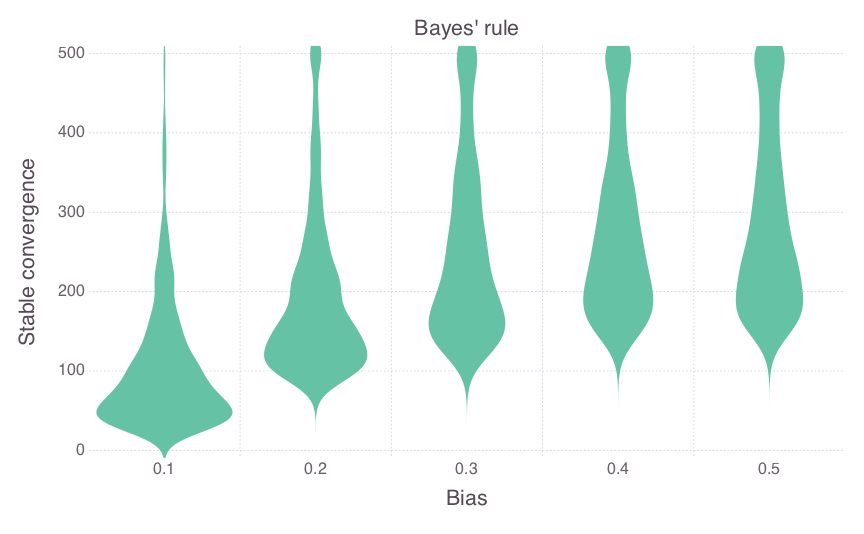

In [13]:
convResBayesS = SharedArray{Int32, 2}(numb_sim, div((numb_hyp - 1), 2));

@sync @parallel for i in 1:div((numb_hyp - 1), 2)
    for j in 1:numb_sim
        convResBayesS[j, i] = ffs(bayesRes, j, i + 1)
    end
end

convResBayesS[convResBayesS.==0] = numb_toss;
convBS = DataFrame(convert(Array, convResBayesS))
names!(convBS, [Symbol("$i") for i in .1:.1:.5])

plot(convBS,
    x=Col.index,
    y=Col.value,
    Geom.violin,
    Coord.Cartesian(ymin=0, ymax=numb_toss),
    Guide.xlabel("Bias"),
    Guide.ylabel("Stable convergence"),
    Guide.title("Bayes' rule"),
    Scale.x_discrete(levels=convB.colindex.names),
    style(default_color=colorant"#66c2a5",
        minor_label_font_size=12pt, major_label_font_size=16pt))

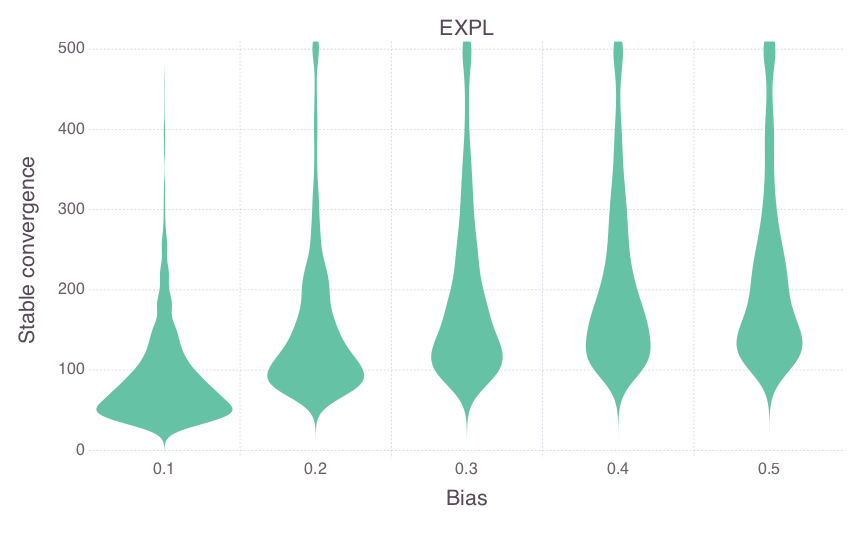

In [14]:
convResEXPLS = SharedArray{Int32, 2}(numb_sim, div((numb_hyp - 1), 2));

@sync @parallel for i in 1:div((numb_hyp - 1), 2)
    for j in 1:numb_sim
        convResEXPLS[j, i] = ffs(explRes, j, i + 1)
    end
end

convResEXPLS[convResEXPLS.==0] = numb_toss;
convES = DataFrame(convert(Array, convResEXPLS))
names!(convES, [Symbol("$i") for i in .1:.1:.5])

plot(convES,
    x=Col.index,
    y=Col.value,
    Geom.violin,
    Coord.Cartesian(ymin=0, ymax=numb_toss),
    Guide.xlabel("Bias"),
    Guide.ylabel("Stable convergence"),
    Guide.title("EXPL"),
    Scale.x_discrete(levels=convB.colindex.names),
    style(default_color=colorant"#66c2a5",
        minor_label_font_size=12pt, major_label_font_size=16pt))

### Statistics

In [15]:
[ pvalue(MannWhitneyUTest(convB[:, i], convE[:, i])) for i in 1:5 ]

5-element Array{Float64,1}:
 0.912105   
 4.38834e-45
 4.968e-53  
 5.02117e-59
 3.64219e-62

In [16]:
[ pvalue(MannWhitneyUTest(convBS[:, i], convES[:, i])) for i in 1:5 ]

5-element Array{Float64,1}:
 0.166775   
 4.66579e-35
 3.27818e-48
 2.28656e-63
 2.19436e-59

### Scoring

In [17]:
function brierScore(mat, r, sim, hyp)
    (1 - mat[r, :, sim, hyp][hyp])^2 + sum((deleteat!(mat[r, :, sim, hyp], hyp)).^2)
end

function brierVals(mat, sim, hyp)
    vals = Float64[]
    for i in 1:numb_toss
        push!(vals, brierScore(mat, i + 1, sim, hyp))
    end
    return vals
end

brierVals (generic function with 1 method)

In [18]:
brierBayesRes = Array{Float64}(numb_toss, numb_sim, numb_hyp);

for i in 1:numb_hyp
    for j in 1:numb_sim
        brierBayesRes[:, j, i] = brierVals(bayesRes, j, i)
    end
end

brierBayesMeans = Array{Float64}(numb_toss, numb_hyp);

for i in 1:numb_hyp
    brierBayesMeans[:, i] = mean(brierBayesRes[:, :, i], 2)
end

brierEXPLRes = Array{Float64}(numb_toss, numb_sim, numb_hyp);

for i in 1:numb_hyp
    for j in 1:numb_sim
        brierEXPLRes[:, j, i] = brierVals(explRes, j, i)
    end
end

brierEXPLMeans = Array{Float64}(numb_toss, numb_hyp);

for i in 1:numb_hyp
    brierEXPLMeans[:, i] = mean(brierEXPLRes[:, :, i], 2)
end

In [19]:
bayesConf = Array{Float64, 2}(11, 3)

for i in 1:11
    bayesConf[i, :] = vcat(mean(brierBayesMeans[:, i]), [confint(OneSampleTTest(brierBayesMeans[:, i]))...])
end

explConf = Array{Float64, 2}(11, 3)

for i in 1:11
    explConf[i, :] = vcat(mean(brierEXPLMeans[:, i]), [confint(OneSampleTTest(brierEXPLMeans[:, i]))...])
end

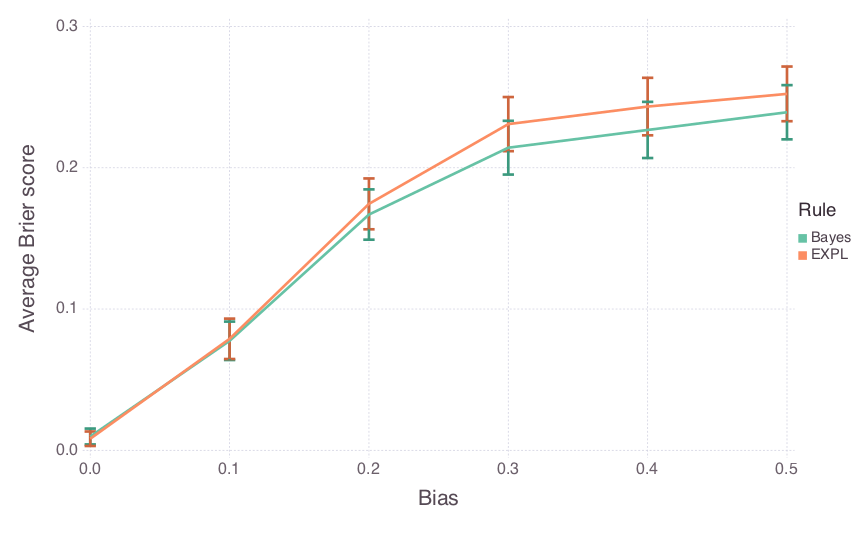

In [20]:
conf_df = convert(DataFrame, vcat(bayesConf, explConf))
names!(conf_df, [Symbol("$i") for i in ["y", "ymin", "ymax"]])
conf_df[:Bias] = repeat(collect(0.0:0.1:1.0), outer=2)
conf_df[:Rule] = repeat(["Bayes", "EXPL"], inner=11)
conf5_df = conf_df[conf_df[:Bias].<0.6,:]

ticks = collect(0.0:0.1:0.5)
plot(conf5_df, x=:Bias, y=:y, ymin=:ymin, ymax=:ymax, color=:Rule, Geom.line, Geom.errorbar,
    Guide.ylabel("Average Brier score"),
    Guide.xticks(ticks=ticks),
    Scale.color_discrete_manual(gen_brew_colors(2)...),
    style(line_width=2pt, minor_label_font_size=12pt, major_label_font_size=16pt,
            key_label_font_size=11pt, key_title_font_size=14pt,
            colorkey_swatch_shape=:square))

### Statistics

In [21]:
[ pvalue(EqualVarianceTTest(brierBayesMeans[:, i], brierEXPLMeans[:, i])) for i in 1:6 ]

6-element Array{Float64,1}:
 0.682709
 0.889121
 0.557745
 0.224555
 0.253217
 0.348881